In [1]:
import argparse
import datetime
import logging
import os
import pdb

import cartopy.crs as ccrs
import cartopy.feature as cfeature

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#from hwtmode.data import decompose_circular_feature
from matplotlib.colors import BoundaryNorm, ListedColormap

sns.set_theme()
import xarray

from ml_functions import (
    assertclose,
    brier_skill_score,
    configs_match,
    get_argparser,
    get_args,
    get_features,
    get_ifiles,
    load_df,
    rptdist2bool,
)

logging.basicConfig(format="%(asctime)s %(message)s", level=logging.INFO)

2024-09-20 10:14:11.981983: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-20 10:14:14.749323: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
o_thresh = 1
twin = 2
rptdist = 20
args = get_args(o_thresh, twin)
args

Namespace(batchnorm=True, batchsize=1024, clobber=False, debug=False, dropout=0.0, epochs=30, labels=['cg_20km_2hr', 'ic_20km_2hr', 'cg.ic_20km_2hr', 'flashes_20km_2hr', 'cg_40km_2hr', 'ic_40km_2hr', 'cg.ic_40km_2hr', 'flashes_40km_2hr'], fhr=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], fits=None, flash=1, folds=None, kfold=1, idate=None, ifile=None, learning_rate=0.001, model='HRRR', neurons=[1024], nfits=10, nprocs=0, optimizer='Adam', reg_penalty=0.0, savedmodel='/glade/work/ahijevyc/NSC_objects/nn/lightning/001+.2hr', seed=-1, trainstart=Timestamp('2019-10-02 00:00:00'), trainend=Timestamp('2020-12-02 00:00:00'), teststart=Timestamp('2021-01-01 00:00:00'), testend=Timestamp('2022-01-01 00:00:00'), twin=2, suite='default')

In [4]:
logging.info("load wbug lightning data")
wbugdir = "/glade/campaign/mmm/parc/ahijevyc/ENTLN"
wbug = xarray.open_dataset(
    os.path.join(wbugdir, f"flash.{rptdist}km_30min.nc"), chunks=None
)

2024-09-20 10:29:39,677 load wbug lightning data


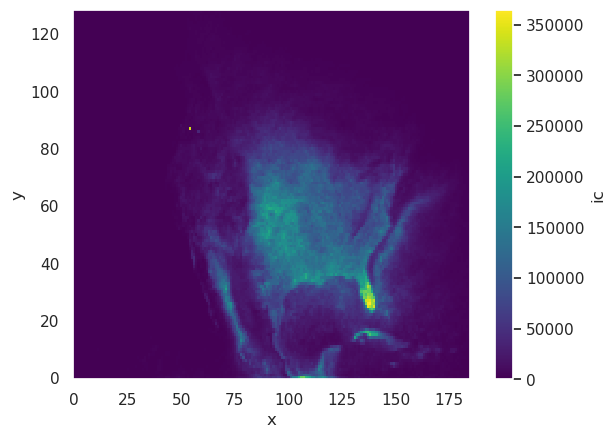

In [5]:
wbug["ic"].sum(dim="time_coverage_start").plot()

In [6]:
y, x = 32, 66
# i = wbug.isel(y=y, x=x).idxmax()
time_range = slice("20180806T0400", "20180806T0900")
wbug.isel(y=y, x=x).sel(time_coverage_start=time_range).ic.astype(int)

<xarray.DataArray 'ic' (time_coverage_start: 11)>
array([   0,    0,   92, 1152, 1462,  492,  216,   43,   11,    7,    0])
Coordinates:
  * time_coverage_start  (time_coverage_start) datetime64[ns] 2018-08-06T04:0...
    lon                  float64 ...
    lat                  float64 ...

In [7]:
time_range_plusminus_twin = slice(
    pd.to_datetime(time_range.start) - twin * pd.Timedelta(hours=twin),
    pd.to_datetime(time_range.stop) + twin * pd.Timedelta(hours=twin),
)
time_range_plusminus_twin

slice(Timestamp('2018-08-06 00:00:00'), Timestamp('2018-08-06 13:00:00'), None)

In [8]:
offset = pd.Timedelta(hours=twin / 2) if twin == 1 else None
wbug1 = (
    wbug.isel(y=y, x=x).sel(
        time_coverage_start=time_range_plusminus_twin
    )
    .resample(
        time_coverage_start=f"{twin}h",
        offset=offset,
        skipna=True,  # True in ml_functions
    )
    .mean()
    * twin
    * 2
)

valid_time = wbug1.time_coverage_start.data + pd.Timedelta(hours=twin / 2)
wbug1 = (
    wbug1.assign_coords({"valid_time": ("time_coverage_start", valid_time)})
    .swap_dims({"time_coverage_start": "valid_time"})
    .ic
)

In [9]:
# more complicated version of wbug3 below
wbug2 = (
    (
        # If you shift with missing times, shifting by constant index is not constant in time.
        # Therefore, resample at 30-min interval. fill in missing 30-minute times with nans
        wbug.isel(y=y, x=x).sel(
            time_coverage_start=time_range_plusminus_twin
        )
        .resample(time_coverage_start="30min")
        .first()
        .shift(time_coverage_start=-twin * 2 + 1)
        .rolling(
            dim={"time_coverage_start": twin * 2},
            min_periods=twin,
        )
        .mean()
        * twin
        * 2
    )
    .resample(time_coverage_start=f"1h", offset="30min" if twin == 1 else None).first()
    # tried coarsen - dask's resample is inefficient https://github.com/pydata/xarray/discussions/5753
    # but couldnt use .first(); only mean() or median, which is not what I want.
)

valid_time = wbug2.time_coverage_start.data + pd.Timedelta(hours=twin / 2)
wbug2 = (
    wbug2.assign_coords(valid_time=("time_coverage_start", valid_time))
    .swap_dims({"time_coverage_start": "valid_time"})
    .ic
)

In [10]:
wbug3 = (
    wbug.isel(y=y, x=x)
    .sel(time_coverage_start=time_range_plusminus_twin)
    .resample(time_coverage_start="30min")
    .first()
    .rolling(
        dim={"time_coverage_start": twin * 2},
        min_periods=twin,
        center=True,
    )
    .mean()
    .rename({"time_coverage_start": "valid_time"})
    .ic
    * twin
    * 2
)

In [11]:
wbug3

<xarray.DataArray 'ic' (valid_time: 27)>
array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         92., 1244., 2706., 3198., 3322., 2213.,  762.,  277.,   61.,
         18.,    7.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])
Coordinates:
    lon         float64 -110.8
    lat         float64 28.45
  * valid_time  (valid_time) datetime64[ns] 2018-08-06 ... 2018-08-06T13:00:00

<xarray.DataArray 'ic' (valid_time: 13)>
array([   0.,    0.,    0.,    0., 1244., 3198., 2213.,  277.,   18.,
          0.,    0.,    0.,    0.])
Coordinates:
    lon                  float64 -110.8
    lat                  float64 28.45
    time_coverage_start  (valid_time) datetime64[ns] 2018-08-06 ... 2018-08-0...
  * valid_time           (valid_time) datetime64[ns] 2018-08-06T01:00:00 ... ...

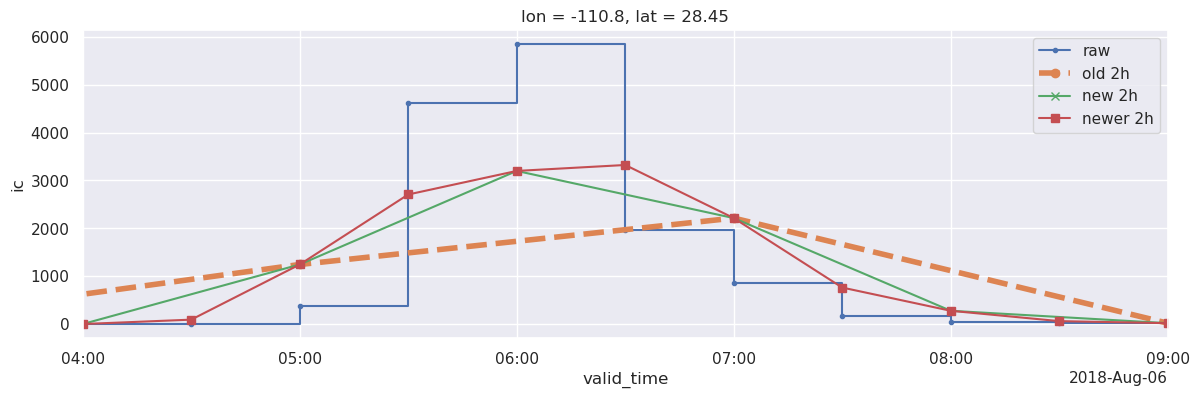

In [12]:
fig, ax = plt.subplots(figsize=(14, 4))
# multiply by time window length in hours times two
(wbug.isel(y=y, x=x).ic.sel(time_coverage_start=time_range) * twin*2).plot.step(
    where="post",
    marker=".", label="raw"
)
wbug1.sel(valid_time=time_range_plusminus_twin).plot(ax=ax, marker="o", label=f"old {twin}h", lw=4, linestyle="dashed")
wbug2.sel(valid_time=time_range_plusminus_twin).plot(ax=ax, marker="x", label=f"new {twin}h")
wbug3.sel(valid_time=time_range_plusminus_twin).plot(ax=ax, marker="s", label=f"newer {twin}h")
plt.legend()
ax.set_xlim(pd.to_datetime(time_range.start), pd.to_datetime(time_range.stop))
wbug2.sel(valid_time=time_range_plusminus_twin)

In [13]:
df = load_df(args, wbugdir="/glade/campaign/mmm/parc/ahijevyc/ENTLN")

2024-09-20 10:43:20,040 reading /glade/derecho/scratch/ahijevyc/tmp/HRRR.2hr.par 35.7G mtime Thu Dec 14 18:04:11 2023 240 features 8 labels and 4 index_cols & dropna.


In [14]:
df.head(10000)[::1308]

,CAPESHEAR,CAPESHEAR-N3T1,CAPESHEAR-N3T3,CAPESHEAR-N3T5,CAPESHEAR-N5T1,CAPESHEAR-N5T3,CAPESHEAR-N5T5,CREF,CREF-N3T1,CREF-N3T3,...,cg.ic_20km_2hr,flashes_20km_2hr,cg_40km_2hr,ic_40km_2hr,cg.ic_40km_2hr,flashes_40km_2hr,initialization_time,valid_time,y,x
pt,,,,,,,,,,,,,,,,,,,,,
1,1741.757324,3041.015381,3144.277100,3382.853516,4213.750977,4255.433105,4422.460938,-10.000000,-9.686814,-8.962192,...,0.0,0.0,0.0,0.0,0.0,0.0,2019-10-02,2019-10-02 03:00:00,12,48
1,1829.926025,3391.423828,3474.655029,3644.268066,4492.552246,4561.542480,4681.601074,-10.000000,-9.629458,-9.036094,...,0.0,0.0,0.0,0.0,0.0,0.0,2019-10-02,2019-10-02 04:00:00,12,48
1,1898.589478,3991.525635,4059.977539,4133.328613,4978.324707,5044.752441,5114.850586,-10.000000,-9.036094,-7.945816,...,0.0,0.0,0.0,0.0,0.0,0.0,2019-10-02,2019-10-02 05:00:00,12,48
1,2338.633789,4796.982910,4744.734863,4773.835449,5663.380859,5622.649902,5628.178223,-10.000000,-7.945816,-7.945816,...,0.0,0.0,0.0,0.0,0.0,0.0,2019-10-02,2019-10-02 06:00:00,12,48
1,3167.661865,5445.694824,5495.409180,5534.027832,6226.244141,6223.337402,6200.187012,-10.000000,-8.951903,-5.839163,...,0.0,0.0,0.0,0.0,0.0,0.0,2019-10-02,2019-10-02 07:00:00,12,48
1,4560.557617,6243.549805,6293.876953,6255.897949,6780.387695,6786.410156,6709.833984,-10.000000,-5.839163,-5.839163,...,0.0,0.0,0.0,0.0,0.0,0.0,2019-10-02,2019-10-02 08:00:00,12,48
1,6352.519043,7192.384766,7012.270996,6817.945801,7352.598145,7219.848145,7064.835449,-9.965192,-5.955247,-5.794839,...,0.0,0.0,0.0,0.0,0.0,0.0,2019-10-02,2019-10-02 09:00:00,12,48
1,6463.265625,7600.877441,7466.827637,7220.721680,7526.560059,7439.181641,7285.899902,-9.124572,-5.794839,-3.249143,...,0.0,0.0,0.0,0.0,0.0,0.0,2019-10-02,2019-10-02 10:00:00,12,48


In [15]:
dfb = rptdist2bool(df, args)

2024-09-20 11:25:50,217 use [0, 1, 2] time win for 8 lsrtypes until parquet renamed [1,2,4]
2024-09-20 11:25:50,222 Convert severe report distance to boolean [0,20km) = True
2024-09-20 11:25:50,245 threshold wbug at 1 flashes
2024-09-20 11:25:58,597 use [0, 1, 2] time win for 8 lsrtypes until parquet renamed [1,2,4]
2024-09-20 11:25:58,599 Convert severe report distance to boolean [0,40km) = True
2024-09-20 11:25:58,600 threshold wbug at 1 flashes


In [13]:
dfb[label_cols]  # .loc[(time_range,slice(None),slice(None))]

NameError: name 'label_cols' is not defined

In [ ]:
dfb[label_cols].mean(axis=0)

In [ ]:
dfb[label_cols].mean(axis=0)

In [ ]:
df_test = dfb[
    (dfb.initialization_time >= args.teststart)
    & (dfb.initialization_time <= args.testend)
]

In [ ]:
df_test.groupby("forecast_hour")["sigwind_40km_2hr"].mean().plot()

In [ ]:
df.loc[("2020-06-20 00:00:00", 46, 25)]

In [ ]:
df.xs(
    slice("2020-06-20 00:00:00", "2020-06-20 00:00:00"),
    level="valid_time",
    drop_level=False,
).xs(46, level="y", drop_level=False).xs(25, level="x", drop_level=False)

In [ ]:
mdf = dfb[label_cols].groupby(["y", "x"]).sum()  # for debug plot

In [ ]:
df[["initialization_time", "forecast_hour", "ic_40km_hourly"]].groupby(
    "forecast_hour"
).mean().plot()

In [ ]:
dfb[["initialization_time", "forecast_hour", "ic_40km_2hr"]].groupby(
    "forecast_hour"
).mean().plot()

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
for label, ax in zip(label_cols, axes.flatten()):
    im = ax.scatter(
        mdf.index.get_level_values("y"),
        mdf.index.get_level_values("x"),
        c=mdf[label],
        s=3,
        marker="s",
    )  # Don't use mdf (sum) for lon/lat
    ax.set_title(label)
    fig.colorbar(im, ax=ax)